# Problem Set 3, due Wednesday, May 3rd, 5:30pm.

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz (available on Canvas).  The data
(progresa_sample.csv.gz) is available on canvas
in files/data.

Please read the paper to familiarize yourself with
the PROGRESA program before beginning this problem set, so you have a
rough sense of where the data come from and how they were
generated. If you just proceed into the problem set without
understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic
econometric techniques that you are learning in class to measure the
impact of Progresa on secondary school enrollment rates, in particular
differences-in-differences.  Your task is to **estimate the impact of
_progresa_ subsidies on the school attendance**.  Note: this asks to
estimate a causal effect.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from
Canvas. The data are actual data collected to evaluate the impact of
the Progresa program.  In this file, each row corresponds to an
observation taken for a given child for a given year. There are two
years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the
following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |treatment = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Report summary statistics (mean, standard deviation, and number of missings) for all of
the demographic variables in the dataset (i.e., everything except
year, folnum, village).  Present the actual levels for 'progresa' and
'poor'.  Do these fit with the documentation above?

Present these in a single table alphabetized
by variable name. Do NOT simply expect the grader to scroll through
your output!

In [1]:
# Import pandas module
import pandas as pd

# Import 'progresa' data
data_progresa = pd.read_csv('progresa_sample.csv.gz')

# Calculate the summary statistics
print("Summary Statistics - Report:\n")
data_mean = data_progresa.drop(['year', 'folnum', 'village'], axis = 1).mean().to_frame(name = 'Mean')
data_std = data_progresa.drop(['year', 'folnum', 'village'], axis = 1).std().to_frame(name = 'Standard Deviation')
data_isnull = data_progresa.drop(['year', 'folnum', 'village'], axis = 1).isnull().sum().to_frame(name = 'Count of Nulls')

# Concatenate the three summary statistics: (mean, standard deviation, and number of missings)
pd.concat([data_mean, data_std, data_isnull], axis = 1)

Summary Statistics - Report:



,Mean,Standard Deviation,Count of Nulls
age,11.366460,3.167744,0
dist_cap,147.674452,76.063134,0
dist_sec,2.418910,2.234109,0
fam_n,7.215715,2.352900,0
grc,3.963537,2.499063,6549
grc97,3.705372,2.572387,0
hohage,44.436717,11.620372,10
hohedu,2.768104,2.656106,0
hohsex,0.925185,0.263095,20
hohwag,586.985312,788.133664,0


In [2]:
# Print the 'progresa' levels
print("'progresa' Levels:\n")
print(data_progresa.groupby('progresa')['progresa'].count().to_frame(name = 'Count'))

# Print the % of 'progresa' levels
print("\n'progresa' Levels (%):\n")
print("0 \t", round(data_progresa.groupby('progresa')['progresa'].count()['0'] / data_progresa['progresa'].count() * 100, 2))
print("basal \t", round(data_progresa.groupby('progresa')['progresa'].count()['basal'] / data_progresa['progresa'].count() * 100, 2))

# Print the 'poor' levels
print("\n'poor' Levels:\n")
print(data_progresa.groupby('poor')['poor'].count().to_frame(name = 'Count'))

# Print the % of 'poor' levels
print("\n'poor' Levels (%):\n")
print("no pobre ", round(data_progresa.groupby('poor')['poor'].count()['no pobre'] / data_progresa['poor'].count() * 100, 2))
print("pobre    ", round(data_progresa.groupby('poor')['poor'].count()['pobre'] / data_progresa['poor'].count() * 100, 2))

'progresa' Levels:

          Count
progresa       
0         29690
basal     47560

'progresa' Levels (%):

0 	 38.43
basal 	 61.57

'poor' Levels:

          Count
poor           
no pobre  11858
pobre     65392

'poor' Levels (%):

no pobre  15.35
pobre     84.65


Yes, the observations related to 'progresa' levels fit the documentation provided, as we do have '0' (control) and 'basal' (treatment) levels which conform with the documentation provided. This is true for 'poor' levels as well, as we have 'pobre' (poor) and 'no pobre' (not poor) as mentioned in the documentation.

### 1.2 Differences at baseline?
Now let's investigate the differences in baseline.  Are the baseline (1997) demographic characteristics **for the poor**
different in treatment and control villages?

I suggest you to use a T-Test to
determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset. Focus only
on the data from 1997 for poor.

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [3]:
# Import 'numpy' and 'stats' from 'scipy' module
import numpy as np
from scipy import stats

# Create the baseline (1997, and 'pobre') dataframe 
data_progresa_base = data_progresa[np.logical_and(data_progresa['year'] == 97, 
                                                  data_progresa['poor'] == 'pobre')]

# Separate treatment and control villages
base_control = data_progresa_base.drop(['year', 'folnum', 'village'], axis = 1)[data_progresa_base['progresa'] == '0']
base_treatment = data_progresa_base.drop(['year', 'folnum', 'village'], axis = 1)[data_progresa_base['progresa'] == 'basal']

# Find the corresponding average values for treatment and control villages
mean_base_control = base_control.mean().to_frame(name = 'Average Value (Control Villages)')
mean_base_treatment = base_treatment.mean().to_frame(name = 'Average Value (Treatment Villages)')
difference_mean = (mean_base_treatment.iloc[:, 0] - mean_base_control.iloc[:, 0]).to_frame(name = 'Difference (Treatment - Control)')

# Get all the column names
var = list(difference_mean.index)

# Create an empty dictionary
p_value = {}

# Calculate the p-value as per the t-test
for i in var:
    if i == 'progresa':
        continue
    t_test = stats.ttest_ind(base_control[i].dropna(), base_treatment[i].dropna())
    p_value[i] = round(t_test.pvalue, 6)
    
# Convert p_value dictionary to data frame
p_value_df = pd.DataFrame.from_dict(p_value, orient = 'index')
p_value_df.columns = ['p-value']

# Print the final dataframe in the desired format
print("Differences at Baseline:\n")
pd.concat([mean_base_treatment, mean_base_control, difference_mean, p_value_df], axis = 1)

Differences at Baseline:



,Average Value (Treatment Villages),Average Value (Control Villages),Difference (Treatment - Control),p-value
age,10.716991,10.742023,-0.025032,0.478559
dist_cap,150.829074,153.769730,-2.940656,0.000842
dist_sec,2.453122,2.507662,-0.054540,0.035698
fam_n,7.281327,7.302469,-0.021142,0.427104
grc,3.531599,3.543050,-0.011450,0.689015
grc97,3.531599,3.543050,-0.011450,0.689015
hohage,43.648828,44.276918,-0.628090,0.000002
hohedu,2.663139,2.590348,0.072791,0.011051
hohsex,0.924656,0.922947,0.001709,0.571186
hohwag,544.339544,573.163558,-28.824015,0.000325


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

A: Yes, we observe that we have statistically significant differences between treatment and control villages as baseline for the following variables (p-value < 0.05):

- dist_cap: min distance to the capital

- dist_sec: nearest distance to a secondary school

- hohage: age of head of household

- hohedu: years of schooling of head of household

- hohwag: monthly wages of head of household

- min_dist: min distance to an urban center

- sex: male = 1

- welfare_index: welfare index used to classify poor

B: It matters if there are differences at baseline because we should be aware of these differences while making casual inferences related to the impact of the treatment. Collection of pre-program data is essential in analyzing the impact of the treatment or making the before-after comparisons. If the pre-program data indicates that there are differences at the baseline, it gets hard to make causal inferences because the effect of the treatment may be different in the control and treated group.

C: This suggests that it will be required to subtract these differences and it will be useful to employ the difference-in-difference estimator to analyze the impact of the treatment. However, we may run a risk of over-estimating or under-estimating the impact due to the observed differences in baseline.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average
enrollment rate in 1997. Create a scatterplot that shows this
relationship. What do you notice?

In [4]:
# Import the 'matplotlib.pyplot' module
import matplotlib.pyplot as plt

# Create the requisite plot
plt.style.use('ggplot')                                        # Select 'ggplot' style
plt.figure(figsize=(14,10))                                    # Define figure size
plt.scatter(data_progresa[data_progresa['year'] == 97].groupby(['hohedu']).mean().index, data_progresa[data_progresa['year'] == 97].groupby(['hohedu']).mean().sc97, alpha = 0.8)
                                                               # Create the plot
plt.title('Mean Enrollment Rate - 1997 (by Level of Household Head Education)')                      
                                                               # Define title
plt.ylabel('Mean Enrollment Rate - 1997')                      # Define y-label
plt.xlabel('Level of Household Head Education')                # Define x-label
plt.ylim(-0.05,1.05)                                           # Fix the y-axis limits
plt.show()

# Check the observations were we have the 'hohedu' at 20
print("Observations where 'hohedu' is 20:", (data_progresa['hohedu'] == 20).sum())

Observations where 'hohedu' is 20: 4


We observe that as the 'years of schooling of the head of household' increases, the 'average enrollment rate' increases as well.

The unusual decrease in the value of 'average enrollment rate' for the 20 'years of schooling of the head of household' represents 4 observations from the data provided, which may not reveal any significant trend.  

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households
in treated villages**, before and after treatment.  Specifically, for
each village, calculate the average rate of enrollment of poor
households in treated villages in 1997, then compute the average rate
of enrollment of poor households in treated villages in 1998. Create
two separate histograms showing the distribution of these average
enrollments rates, one histogram for 1997 and one histogram for
1998. On each histogram, draw a vertical line that intersects the
x-axis at the average value (across all households). Does there appear
to be a difference? Is this difference statistically significant?

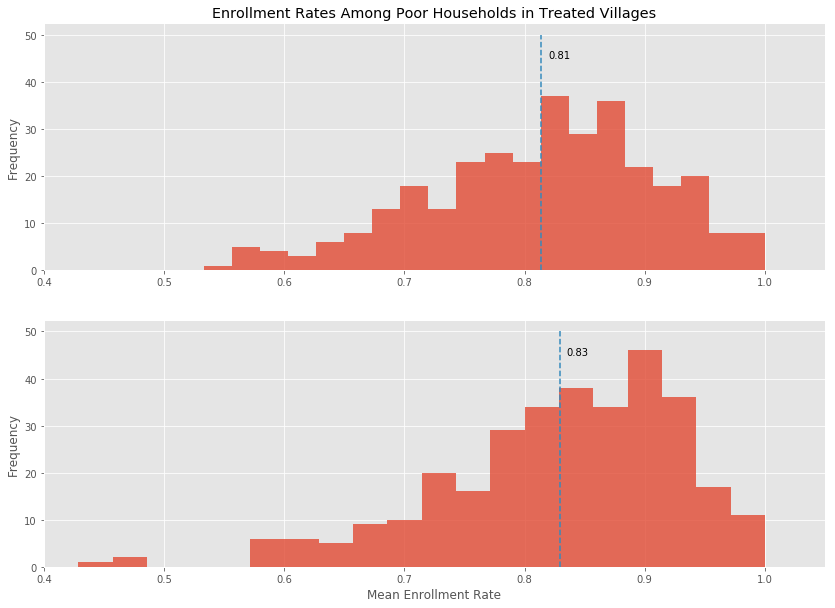

p-value of Enrollment Rates: 0.044249


In [5]:
# Calculate the average value of enrollment rates
data_97 = (data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 97, data_progresa['poor'] == 'pobre'), 
                                           data_progresa['progresa'] == 'basal')].groupby(['village']).mean()['sc97'])

data_98 = (data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 98, data_progresa['poor'] == 'pobre'), 
                                           data_progresa['progresa'] == 'basal')].groupby(['village']).mean()['sc'])
average_97 = data_97.mean()
average_98 = data_98.mean()


# Plot the histograms as required
plt.figure(figsize=(14,10))                                                    # Define the figure size
plt.subplot(2, 1, 1)                                                           # Define the subplot settings
plt.hist(data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 97, data_progresa['poor'] == 'pobre'), 
              data_progresa['progresa'] == 'basal')].groupby(['village']).mean()['sc97'], alpha = 0.8, bins = 20)
                                                                               # Plot the histogram
plt.ylabel('Frequency')                                                        # Define y-label
plt.title('Enrollment Rates Among Poor Households in Treated Villages')        # Define title
plt.plot([average_97, average_97], [0,50], ls = 'dashed')                      # Plot the average line
plt.text(0.82, 45, round(average_97, 2))                                       # Mark the line with text
plt.xlim(0.4, 1.05)

plt.subplot(2, 1, 2)                                                           # Define the subplot settings
plt.hist(data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 98, data_progresa['poor'] == 'pobre'), 
              data_progresa['progresa'] == 'basal')].groupby(['village']).mean()['sc'], alpha = 0.8, bins = 20)
                                                                               # Plot the histogram
plt.ylabel('Frequency')                                                        # Define y-label
plt.xlabel('Mean Enrollment Rate')                                             # Define x-label
plt.plot([average_98, average_98], [0,50], ls = 'dashed')                      # Plot the average line
plt.text(0.835, 45, round(average_98, 2))                                      # Mark the line with text  
plt.xlim(0.4, 1.05)
plt.show() 

print("p-value of Enrollment Rates:", round(stats.ttest_ind(data_97, data_98).pvalue, 6))

Yes, we do observe a statistically significant difference in the two histograms that represents the average enrollment rates among poor households in treated villages, before and after treatment.

This is confirmed by the obtained p-value which is below 0.05.

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor (those with
poor=='pobre'), since only the poor were eligible to receive the
PROGRESA assistance.

### 2.1 Cross-Sectional Estimator: T-test

Begin by estimating the impact of Progresa using "simple differences."
Restricting yourself to data from 1998 (after treatment), calculate
the average enrollment rate among **poor** households in the Treatment
villages and the average enrollment rate among **poor** households in
the control villages. Use a t-test to determine if this difference is
statistically significant. What do you conclude?

In [6]:
# Subset the data to retain only observations corresponding to year 1998 and 'poor'
data_progresa_98 = data_progresa[np.logical_and(data_progresa['year'] == 98, 
                                                data_progresa['poor'] == 'pobre')]


# Print the output of the t-test
cross_sec_ttest = stats.ttest_ind(data_progresa_98[data_progresa_98['progresa'] == '0']['sc'].dropna(), 
                                  data_progresa_98[data_progresa_98['progresa'] == 'basal']['sc'].dropna())
print("Test Statistic (Cross-Sectional Estimator):", round(cross_sec_ttest.statistic, 6))
print("p-value (Cross-Sectional Estimator):", round(cross_sec_ttest.pvalue, 18))

Test Statistic (Cross-Sectional Estimator): -8.358721
p-value (Cross-Sectional Estimator): 6.6e-17


Yes, we observe that the calculated p-value is below 0.05, which suggests that the difference between the enrollment rate in control villages is statistically significantly different than the enrollment rate in treatment villages among poor households in the year 1998 (after treatment).

### 2.2 Cross-Sectional Estimator: Regression

Estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
treatment assignment.  Do not include any additional control
variables.
Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

Note: I recommend to use statsmodels.formula.api as this allows to use
convenient R-style formulas and provedes nice summaries of the results.

In [7]:
# Import the 'statsmodels.formula.api' module
import statsmodels.formula.api as smf

# Create the regression model for 1998 enrollment rates of the poor on treatment assignment
model_regression = smf.ols(formula = 'sc ~ C(progresa)', data = data_progresa_98)
model_regression.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           6.64e-17
Time:                        15:50:06   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.8076      0.004    220.676      0.000       0.800       0.815
C(progresa)[T.basal]     0.0388      0.005      8.359      0.000       0.030       0.048
==============================================================================
Omnibus:                     7638.939   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15767.534
Skew:                          -1.767   Prob(JB):                         0.00
Kurtosis:                       4.140   Cond. No.                         3.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A: We observe that the coefficient of C(progresa)[T.basal] is 0.0388. This suggests that the enrollment rate increases by 0.0388 if treated or if the 'progresa' == 'basal'.

B: We observe that the coefficient of C(progresa)[T.basal] has a t-statistic of 8.359 which matches with the 'statistic' we observed for the t-test. This suggests that the outcome of the regression analysis matches with the outcome of the t-test we conducted for 2.1.

C: Yes, we can reject the null hypothesis that the treatment effects are zero as the p-value is less than 0.05 for the C(progresa)[T.basal]. This suggests that we have statistically significant evidence in the direction of the alternate hypothesis that should allow us to reject the null hypothesis. 

D: The counterfactual assumption that is underlying this regression is that the difference between the control and treated villages for the year 1998 among the poor households would not have been observed if not for 'progresa' (treatment).

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of
relevant control variables. Include, for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [8]:
# Create the multiple regression model for 1998 enrollment rates of the poor on treatment assignment
model_regression_multiple = smf.ols(formula = 'sc ~ C(progresa) + age + dist_sec + C(sex) + hohedu + welfare_index + C(indig)', 
                                    data = data_progresa_98)
model_regression_multiple.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1419.
Date:                Mon, 11 Jun 2018   Prob (F-statistic):               0.00
Time:                        15:50:06   Log-Likelihood:                -7639.4
No. Observations:               27267   AIC:                         1.529e+04
Df Residuals:                   27259   BIC:                         1.536e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.5025      0.014    105.342      0.000       1.475       1.530
C(progresa)[T.basal]     0.0352      0.004      8.799      0.000       0.027       0.043
C(sex)[T.1.0]            0.0310      0.004      7.977      0.000       0.023       0.039
C(indig)[T.1.0]          0.0468      0.004     11.283      0.000       0.039       0.055
age                     -0.0655      0.001    -95.105      0.000      -0.067      -0.064
dist_sec                -0.0117      0.001    -13.361      0.000      -0.013      -0.010
hohedu                   0.0085      0.001     10.951      0.000       0.007       0.010
welfare_index         3.227e-05   1.72e-05      1.872      0.061   -1.52e-06    6.61e-05
==============================================================================
Omnibus:                     2993.090   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4083.947
Skew:                          -0.940   Prob(JB):                         0.00
Kurtosis:                       3.248   Cond. No.                     4.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A: The controls reduces the point estimate of treatment effect from 0.0388 to 0.0352.

B: The controls reduces the standard error on the treatment effect from 0.005 to 0.004.

C: We observe that the treatment effect for 2.3 (0.0352) is different than what we observed in 2.2 (0.0388). This suggests that if we include a set of relevant control variables, we observe that the treatment effect diminishes by 9.28% (0.0036). This change in the value of treatment effect (0.0036) on the enrollment rates of the poor in the year 1998, is explained by the effect of the control variables in the regression. Also, we observe that the coefficient for treatment effect in 2.3 is statistically more significant than what we observed for 2.2.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the
difference in 1998 enrollment rates across villages. An alternative
approach would be to compute the treatment effect using a
difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

* What is the counterfactual assumption underlying this estimate? 


In [9]:
# Calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages
data_progresa_treated_98 = data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 98, 
                                                                       data_progresa['progresa'] == 'basal'), 
                                                        data_progresa['poor'] == 'pobre')]['sc'].mean()
data_progresa_treated_97 = data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 97, 
                                                                       data_progresa['progresa'] == 'basal'), 
                                                        data_progresa['poor'] == 'pobre')]['sc'].mean()
difference_treated = data_progresa_treated_98 - data_progresa_treated_97
print("A: The difference (between 1997 and 1998) in enrollment rates among poor households in treated villages is", 
     round(difference_treated, 4))

# Calculate the difference (between 1997 and 1998) in enrollment rates among poor households in control villages
data_progresa_control_98 = data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 98, 
                                                                       data_progresa['progresa'] == '0'), 
                                                        data_progresa['poor'] == 'pobre')]['sc'].mean()
data_progresa_control_97 = data_progresa[np.logical_and(np.logical_and(data_progresa['year'] == 97, 
                                                                       data_progresa['progresa'] == '0'), 
                                                        data_progresa['poor'] == 'pobre')]['sc'].mean()
difference_control = data_progresa_control_98 - data_progresa_control_97
print("B: The difference (between 1997 and 1998) in enrollment rates among poor households in control villages is", 
     round(difference_control, 4))

# Calculate the difference between these two differences in the estimate
difference_in_difference = difference_treated - difference_control
print("C: The difference between these two differences in the estimate is", round(difference_in_difference, 4))

A: The difference (between 1997 and 1998) in enrollment rates among poor households in treated villages is 0.0238
B: The difference (between 1997 and 1998) in enrollment rates among poor households in control villages is -0.0075
C: The difference between these two differences in the estimate is 0.0313


C:

I:
The estimate of the impact of treatment on the enrollment rates is 0.0313. 

As compared to the simple difference results that we observed earlier (2.2: 0.0388 and 2.3: 0.0352), it has reduced to 0.0313 (reduced by 19.33% as compared to 2.2, and by 11.08% as compared to 2.3) for the difference-in-difference estimator.

II:
The counterfactual assumption underlying this estimate is that in the absence of treatment, the difference between the 'treatment' and the 'control' group would have been constant over time (between 1997 and 1998). This is referred to as the 'parallel trend' assumption. It means that the unobserved characteristics affecting the enrollment rates do not vary over time with treatment status.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment
effects of the program in a difference-in-differences
framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in
  interpreting your coefficients and standard errors, and make sure to
  specify exactly what units you are measuring and estimating.

* How do these estimates of the treatment effect compare to the
  estimates based on the simple difference?

* How do these estimates compare to the difference-in-difference
  estimates from 2.4 above? What accounts for these differences?

* What is the counterfactual assumption underlying this regression? 

In [10]:
# Create the difference-in-difference model for enrollment rates of the poor
data_progresa_poor = data_progresa[data_progresa['poor'] == 'pobre']
diff_in_diff = smf.ols(formula = 'sc ~ C(progresa) * year + age + dist_sec + C(sex) + hohedu + welfare_index + C(indig)', data = data_progresa_poor)
diff_in_diff.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     2488.
Date:                Mon, 11 Jun 2018   Prob (F-statistic):               0.00
Time:                        15:50:07   Log-Likelihood:                -16656.
No. Observations:               58013   AIC:                         3.333e+04
Df Residuals:                   58003   BIC:                         3.342e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.2257      0.425     -2.881      0.004      -2.059      -0.392
C(progresa)[T.basal]         -2.9893      0.539     -5.546      0.000      -4.046      -1.933
C(sex)[T.1.0]                 0.0338      0.003     12.625      0.000       0.029       0.039
C(indig)[T.1.0]               0.0499      0.003     17.363      0.000       0.044       0.055
year                          0.0278      0.004      6.370      0.000       0.019       0.036
C(progresa)[T.basal]:year     0.0309      0.006      5.582      0.000       0.020       0.042
age                          -0.0655      0.000   -143.552      0.000      -0.066      -0.065
dist_sec                     -0.0108      0.001    -17.378      0.000      -0.012      -0.010
hohedu                        0.0075      0.001     13.841      0.000       0.006       0.009
welfare_index              3.555e-05   1.19e-05      2.986      0.003    1.22e-05    5.89e-05
==============================================================================
Omnibus:                     5532.977   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7289.118
Skew:                          -0.866   Prob(JB):                         0.00
Kurtosis:                       3.116   Cond. No.                     3.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A: We observe that the impact of 'progresa' between 1997 and 1998 is given by the coefficient of C(progresa)[T.basal]:C(year)[T.98], 0.0309 (which is statistically significant as the t-statistic is 5.582 and p-value is below 0.05). This suggests that the difference in the enrollment rates among poor households between the 'treatment' and 'control' villages from 1997 and 1998 (difference-in-difference) is given by 0.0309 with a standard error of 0.006. 

B: We see that the impact of treatment reduces from 0.0352 (Answer 2.3) to 0.0309 (12.22%) for the difference-in-difference (regression) including a set of relevant control variables.

C: We see that the impact of treatment reduces from 0.0313 to 0.0309 (1.28%) upon including a set of relevant control variables if we compare with 2.4. The observed decrease in the value of treatment effect is explained by the effect that control variables have on the enrollment rates.

D: The counterfactual assumption underlying this estimate is that in the absence of treatment, the difference between the 'treatment' and the 'control' group would have been constant over time (between 1997 and 1998), dependent on the set of included control variables. It means that the unobserved characteristics affecting the enrollment rates do not vary over time with treatment status.

### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you
  believe that Progresa had a causal impact on the enrollment rates of
  poor households in Mexico?  Explain by referring to the methods and
  results above.

Based on the analysis, we observe that Progresa had a causal impact on the enrollment rates of poor households in Mexico. This is confirmed by the statistically significant (t-statistic: 5.582, p-value: 0.000) coefficient (0.0309) of C(progresa)[T.basal]:year in the difference-in-difference regression analysis. This assumes that the enrollment rates from 1997 to 1998 in the 'treatment' and 'control' villages are not affected by the impact of any unaccounted characteristic ('progresa' is unrelated to any disturbance).